In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [182]:
df = pd.read_csv('/Users/bennyschellinger/Desktop/Data_Science_2024/Projects/ForecastingEnergyConsumption/PJME_hourly.csv')

In [183]:
df.head(5)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


# 0. Data Set Up

In [184]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

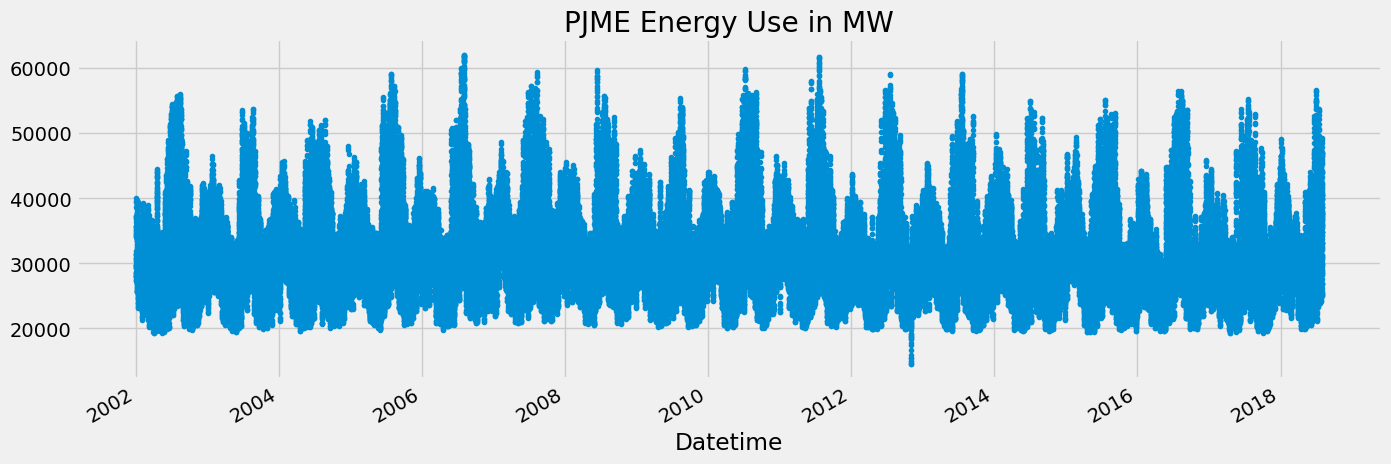

In [185]:
# Plot PJME Energy Use in MW
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW',
        legend = False)
plt.savefig("PJME_Energy_Use")
plt.show()

# 1. Outlier Analysis and Cleaning

<Axes: ylabel='Frequency'>

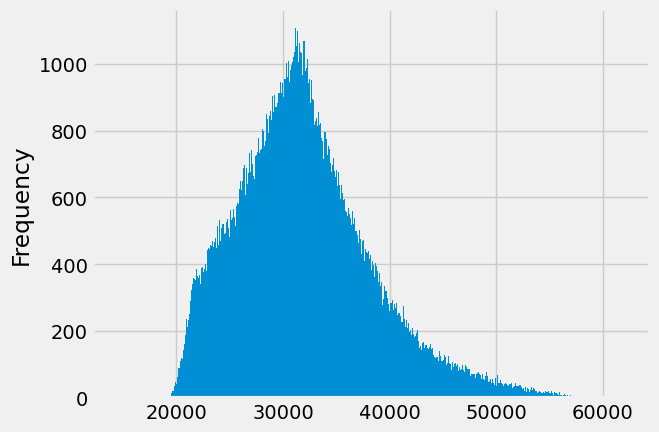

In [186]:
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

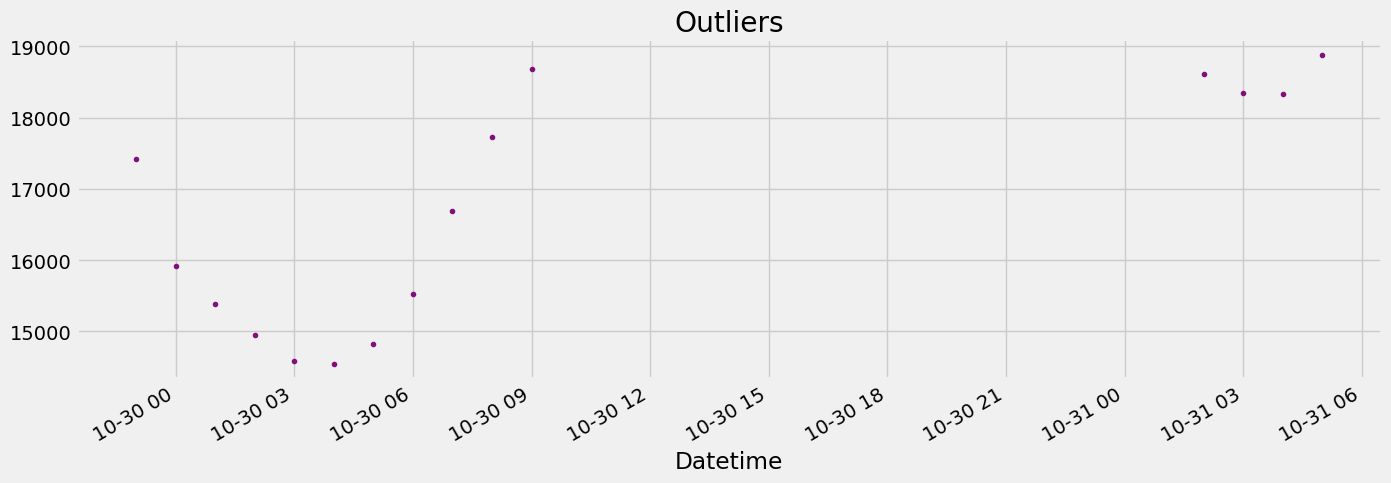

In [187]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [188]:
df = df.query('PJME_MW > 19_000').copy()

# 2. Basic Train / Test Split

In [189]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

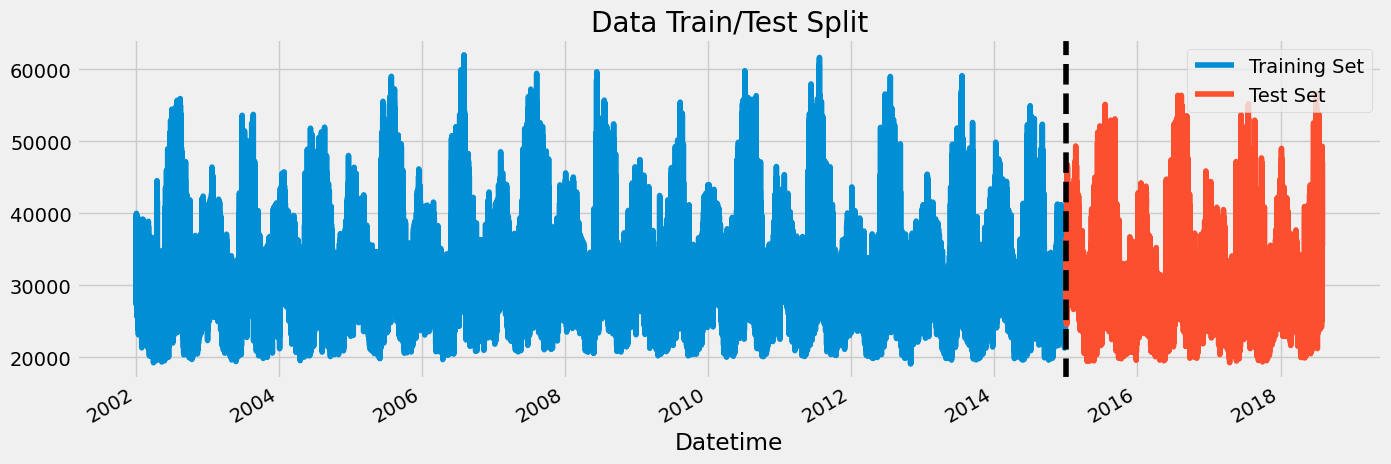

In [190]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--') # threshold line for train / test split
ax.legend(['Training Set', 'Test Set'])
plt.savefig("train_test_split")
plt.show()

# 3. Advanced Train / Test Split

In [23]:
from sklearn.model_selection import TimeSeriesSplit

In [192]:
# Time Series Split generator with 5 splits and 1 year test size with a gap of 24 hours (1 day) between both sets 
tss = TimeSeriesSplit(n_splits=5, test_size=24*364, gap=24)

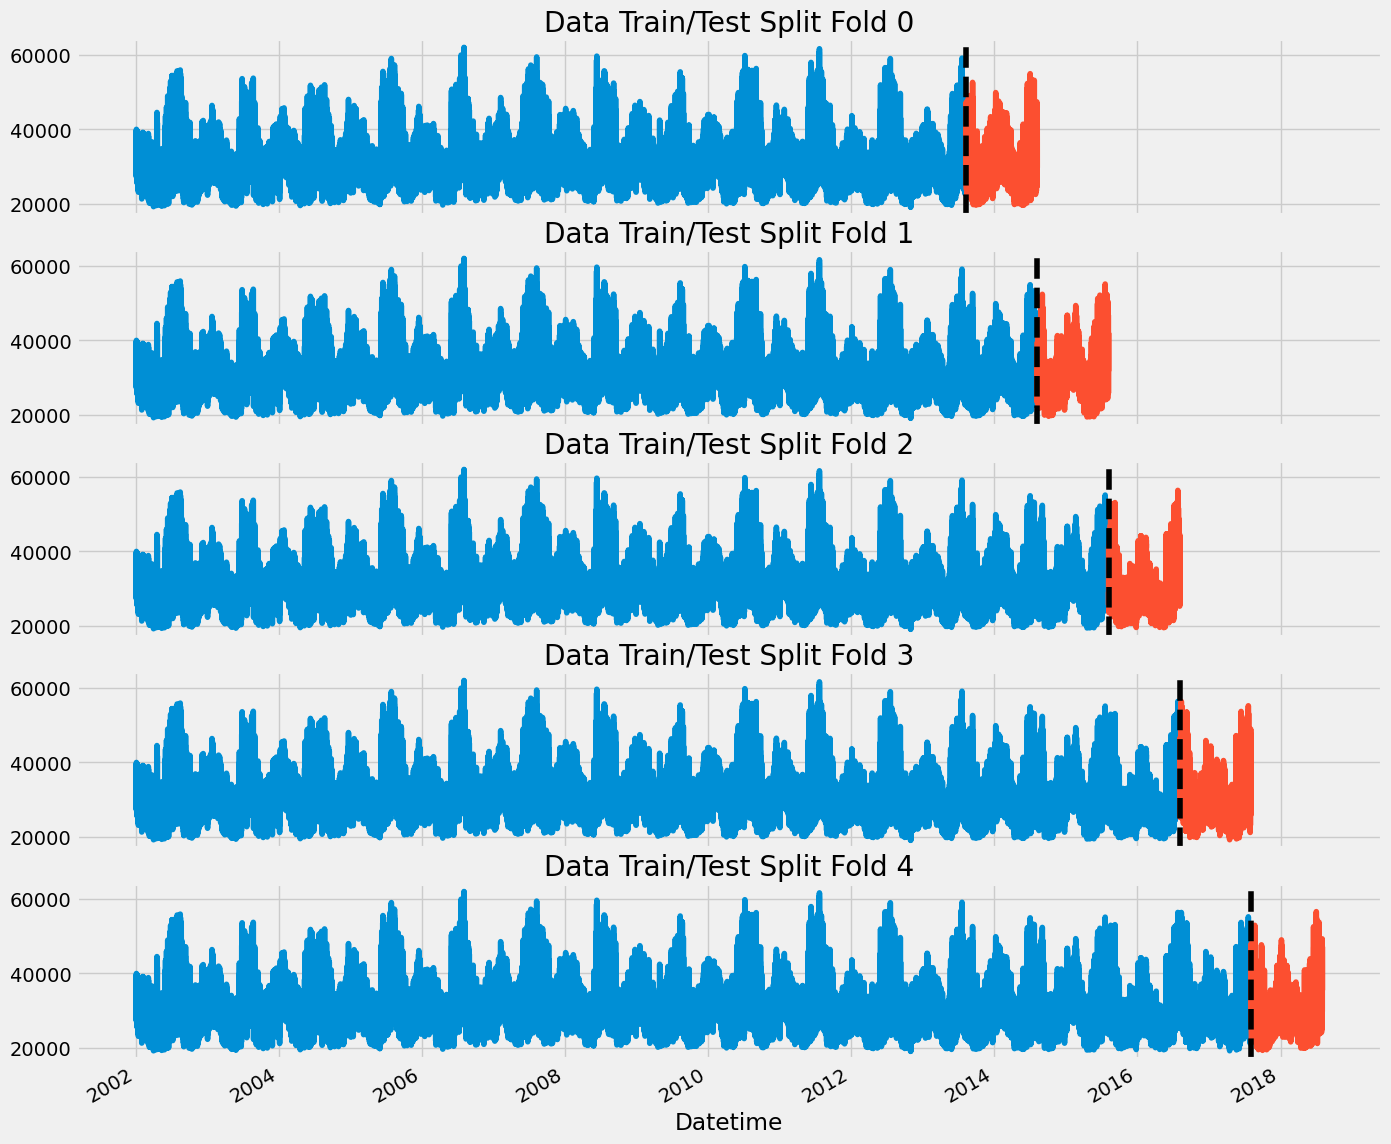

In [193]:
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.savefig("train_test_split_folds")
plt.show()

# 4. Feature Creation

### Forecasting Horizon Explained
The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (<3 months) to long-term horizons (>2 two years).

### Feature Creation based on Time Series Index

In [195]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

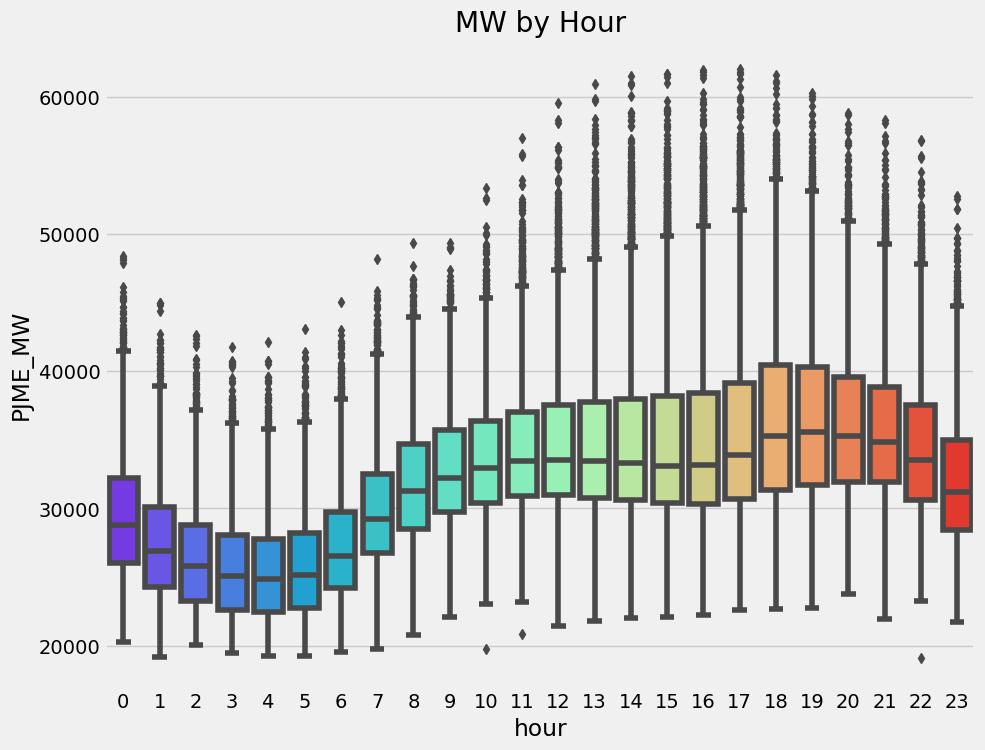

In [196]:
# Visualize Features (MW by Hour) via boxplot

fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(data=df, x='hour', y='PJME_MW',
            palette='rainbow')
# plot.legend_.remove()
# ax.get_legend().remove()
plt.savefig("features_hour")
ax.set_title('MW by Hour');

Text(0.5, 1.0, 'MW by Month')

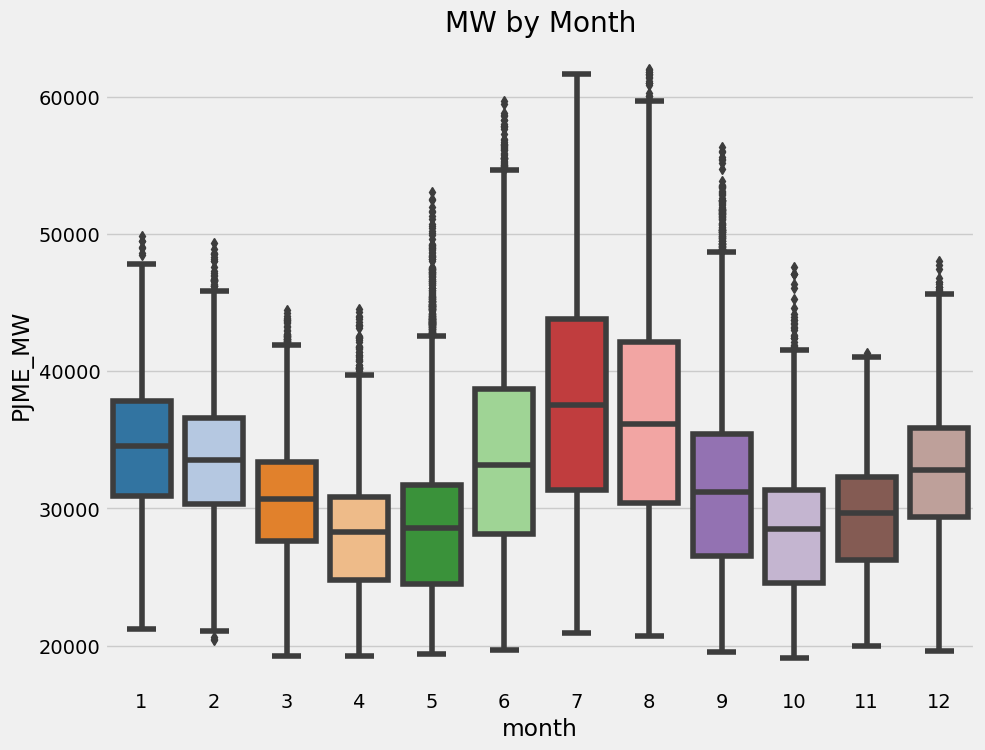

In [197]:
# Visualize Features (MW by Month) via boxplot

fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(data=df, x='month', y='PJME_MW',
#             hue='month', Legend=False,
            palette='tab20')

plt.savefig("features_month")
ax.set_title('MW by Month')

### Lag Features¶
What was the target (x) days in the past.

In [198]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = df['PJME_MW'].shift(365)  # Shift for 1 year, considering leap years
    df['lag2'] = df['PJME_MW'].shift(365 * 2)  # Shift for 2 years
    df['lag3'] = df['PJME_MW'].shift(365 * 3)  # Shift for 3 years
    return df

df = add_lags(df)

# 5. Train Using Cross Validation

In [208]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*364, gap=24)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
TARGET = 'PJME_MW'

preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    '''
    this part is the same as above
    '''
    
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    train = create_features(train)
    val = create_features(val)

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

    #fold += 1

[0]	validation_0-rmse:32732.07743	validation_1-rmse:31990.37150
[100]	validation_0-rmse:12611.21752	validation_1-rmse:11999.66900
[200]	validation_0-rmse:5831.06798	validation_1-rmse:5438.02687
[300]	validation_0-rmse:3900.37400	validation_1-rmse:3861.26382
[400]	validation_0-rmse:3446.12989	validation_1-rmse:3680.41201
[500]	validation_0-rmse:3300.74260	validation_1-rmse:3643.37165
[600]	validation_0-rmse:3223.09775	validation_1-rmse:3633.37037
[700]	validation_0-rmse:3168.64858	validation_1-rmse:3623.20514
[800]	validation_0-rmse:3120.58658	validation_1-rmse:3617.35739
[841]	validation_0-rmse:3103.92242	validation_1-rmse:3617.77995
[0]	validation_0-rmse:32675.16432	validation_1-rmse:32151.60592
[100]	validation_0-rmse:12600.93382	validation_1-rmse:12185.71642
[200]	validation_0-rmse:5837.70222	validation_1-rmse:5600.67238
[300]	validation_0-rmse:3919.43614	validation_1-rmse:4005.26293
[400]	validation_0-rmse:3467.51396	validation_1-rmse:3726.82691
[500]	validation_0-rmse:3324.35293	v

In [209]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3682.6647
Fold scores:[3615.9032255562674, 3446.0541725759253, 3499.6927574984616, 3910.803783409845, 3940.8697528984876]


### Feature Importance

In [210]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

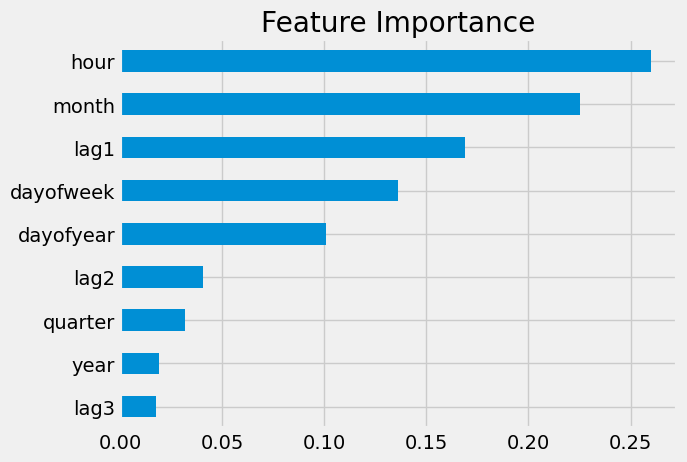

In [211]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', legend = False)
plt.savefig("Feature_importance")

In [216]:
val["prediction"] = reg.predict(X_val)

In [217]:
df = df.merge(val['prediction'], how='left', left_index=True, right_index=True)

Text(0.5, 1.0, 'Raw Data and Prediction')

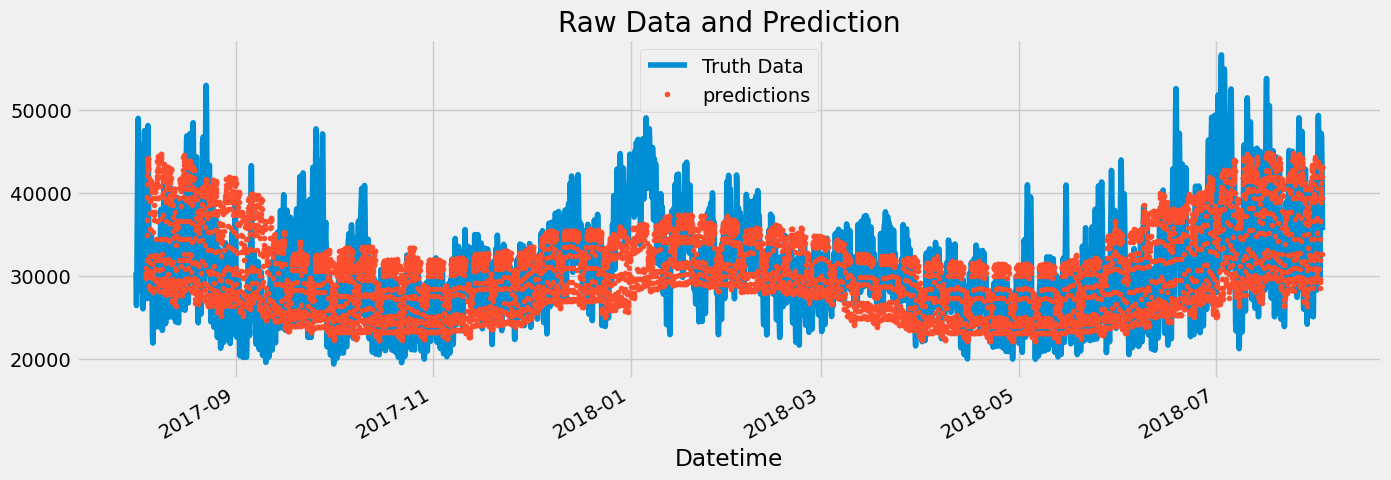

In [229]:
ax = df.loc[df.index > "2017-08-01"]["PJME_MW"].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.savefig("prediction")
plt.legend(['Truth Data','predictions'])
ax.set_title('Raw Data and Prediction')

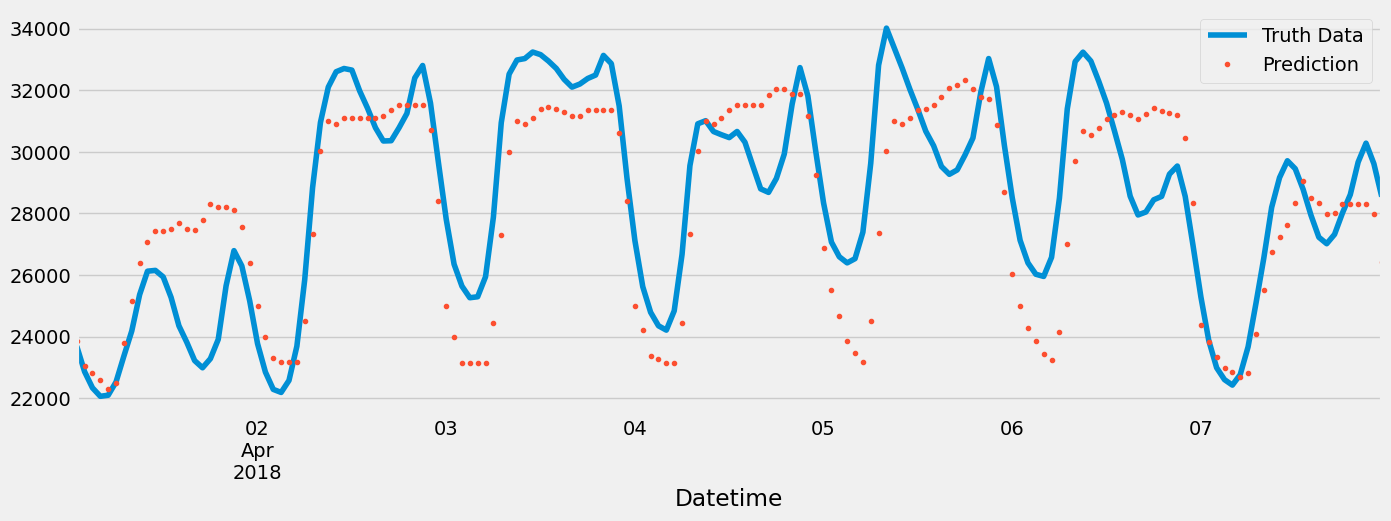

In [228]:
# df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]\
#     [['PJME_MW', 'prediction']].sort_index().plot(figsize=(15, 5));

df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW']\
    .sort_index().plot(figsize=(15, 5))

df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction']\
    .sort_index().plot(style='.')
plt.savefig("prediction_2018")
plt.legend(['Truth Data', 'Prediction']);

In [230]:
score = np.sqrt(mean_squared_error(y_val, val['prediction']))
print(f'RMSE Score on Test set: {score:0.4f}')

RMSE Score on Test set: 3940.8698


-> RMSE Score on Test set: 3741.0302

### Calculate Error

In [232]:
val['error'] = np.abs(y_val - val['prediction'])
val['date'] = val.index.date
val.head(2)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,prediction,error,date
Datetime,,,,,,,,,,,,,,,
2017-08-04 01:00:00,30781.0,1,4,3,8,2017,216,4,31,51440.0,41574.0,41874.0,30937.386719,156.386719,2017-08-04
2017-08-04 02:00:00,29015.0,2,4,3,8,2017,216,4,31,49781.0,42270.0,43999.0,29944.441406,929.441406,2017-08-04


In [235]:
val.groupby('date')['error'].mean().sort_values(ascending=False)

date
2018-01-06    11861.071940
2018-01-07    11303.357503
2018-01-05    10546.089355
2018-07-02     9515.763184
2017-12-31     9142.777913
                  ...     
2018-03-07      748.978109
2018-05-31      706.906006
2018-04-19      648.989827
2018-05-16      603.092448
2018-05-22      596.613770
Name: error, Length: 365, dtype: float64

# 4. Predicting the Future

- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code and lag creation

In [237]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32405.07322
[100]	validation_0-rmse:12540.62121
[200]	validation_0-rmse:5872.94780
[300]	validation_0-rmse:4016.80898
[400]	validation_0-rmse:3576.05753
[499]	validation_0-rmse:3432.33284


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [239]:
df.index.date.max()

datetime.date(2018, 8, 3)

### Create Forecasting Dataframe

In [240]:
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [241]:
future_w_features = df_and_future.query('isFuture').copy()

### Predict the future

In [244]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

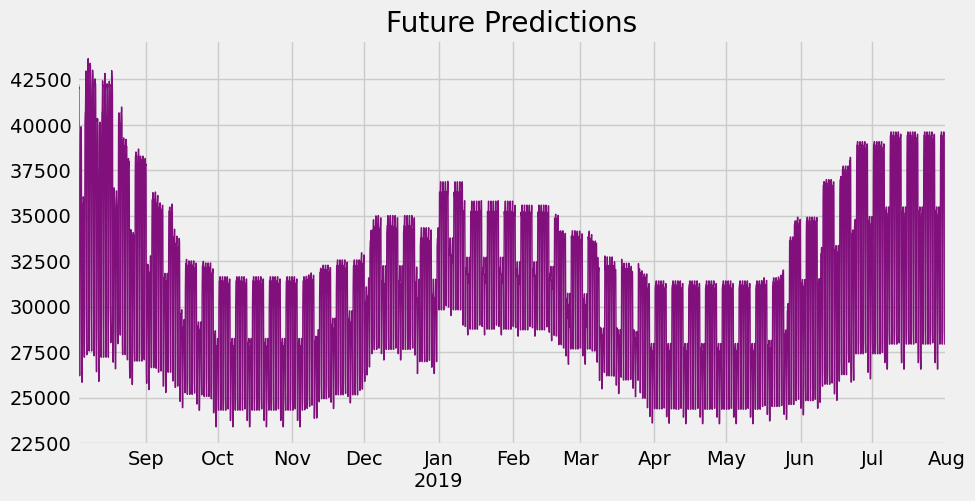

In [251]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[5],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.savefig("future_prediction")
plt.show()

In [252]:
# Save model
reg.save_model('model.json')

### Loading saved model
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[5],
                               ms=1, lw=1,
                               title='Future Predictions')